# T2 mapping

### optional: for parallel computation

In [1]:
# addprocs(Sys.CPU_CORES-nprocs());
# nprocs()

### Loading juila packages

This cell only needs to run once when you start the kernel & this notebook

In [2]:
push!(LOAD_PATH,"library");
using Read_NIfTI1_real
using PyPlot
using NK_tools

### Loading NIfTI file

In [3]:
filename = "data/T2data.nii.gz";
headerinfo = load_niigz_header(filename); 
data = load_niigz_data(filename, headerinfo); # see the source code in library/Read_NIfTI1_real.jl
println("data size : ", size(data))
print("type of data: ", typeof(data))

data size : (192, 192, 4, 11)
type of data: Array{Int16,4}

### Displaying a single slice (e.g., slice # 3) corresponding a certain TE (e.g., the fourth echo)

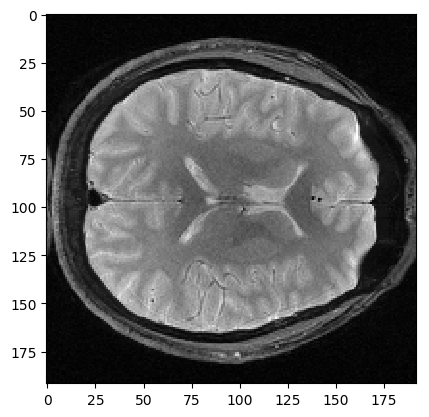

In [4]:
imshow(data[:,:,3,4],cmap="gray", interpolation="none"); # part of PyPlot

### Displaying multiple echoes (in 4 x 3 subplots) for slice #3

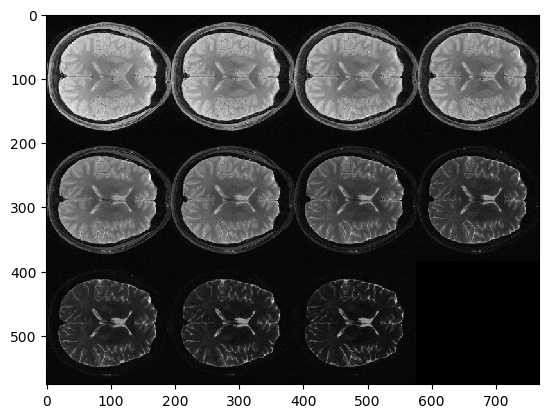

884736

In [5]:
imal(data[:,:,3,:],4,3); # see the source codes in library/NK_tools.jl

###  Converting data to double float format for further analysis

In [6]:
dataDouble = convert(Array{Float64},data);
println("type of data: ", typeof(dataDouble))

type of data: Array{Float64,4}


### T2 fitting for a single voxel (e.g., dataDouble[51,67,3,:] )

* TE value in T2data: 
    [10500.0, 15000.0, 20000.0, 25000.0, 35000.0, 40000.0, 60000.0, 80000.0, 100000.0, 120000.0, 140000.0];

* TE values in in T2stardata: 
    [10000.0, 15000.0, 20000.0, 25000.0, 30000.0, 35000.0, 40000.0, 60000.0, 80000.0, 100000.0, 120000.0, 140000.0]
* Use mricron to select your voxel [https://www.nitrc.org/projects/mricron]


71555.44886031868

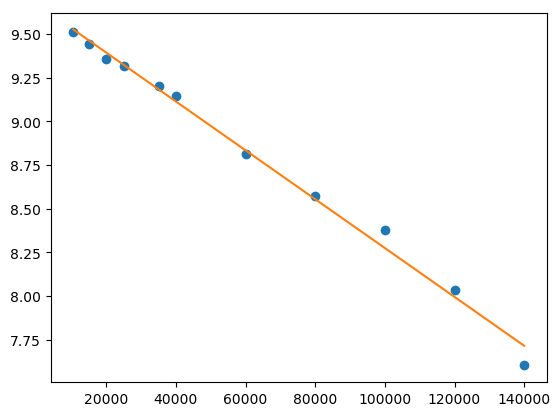

In [7]:
data1D = dataDouble[51,67,3,:];
TEvalue = [10500.0, 15000.0, 20000.0, 25000.0, 35000.0, 40000.0, 60000.0, 80000.0, 100000.0, 120000.0, 140000.0];
# figure(1); plot(TEvalue, data1D)
X = zeros(size(data)[4],2); 
X[:,1] = TEvalue;  X[:,2] = 1.0
coeff = X\log.(data1D)
figure(1); plot(TEvalue, log.(data1D),"o"), plot(TEvalue, coeff[1]*TEvalue + coeff[2]);
display(-1/coeff[1])

### T2 mapping

* TE value in T2data: 
    [10500.0, 15000.0, 20000.0, 25000.0, 35000.0, 40000.0, 60000.0, 80000.0, 100000.0, 120000.0, 140000.0];

* TE values in in T2stardata: 
    [10000.0, 15000.0, 20000.0, 25000.0, 30000.0, 35000.0, 40000.0, 60000.0, 80000.0, 100000.0, 120000.0, 140000.0]


In [8]:
T2map = zeros(size(data)[1],size(data)[2],size(data)[3]);
# T2map = SharedArray{Float64,3}((size(data)[1],size(data)[2],size(data)[3])); # this is for parallel computation
TEvalue = [10500.0, 15000.0, 20000.0, 25000.0, 35000.0, 40000.0, 60000.0, 80000.0, 100000.0, 120000.0, 140000.0];
X = zeros(size(data)[4],2); 
X[:,1] = TEvalue;  X[:,2] = 1.0
# @sync @parallel for cntz = 1:size(data)[3]
for cntz = 1:size(data)[3]
    for cnty = 1:size(data)[2]
        for cntx = 1:size(data)[1]
            data1D = dataDouble[cntx,cnty,cntz,:];
            coeff = X\log.(data1D)
            T2map[cntx,cnty,cntz]=-1/coeff[1];
        end
    end
end

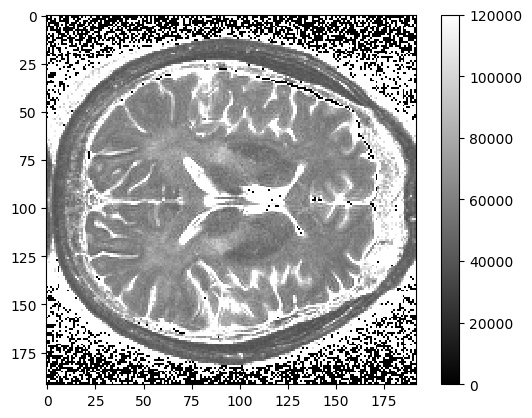

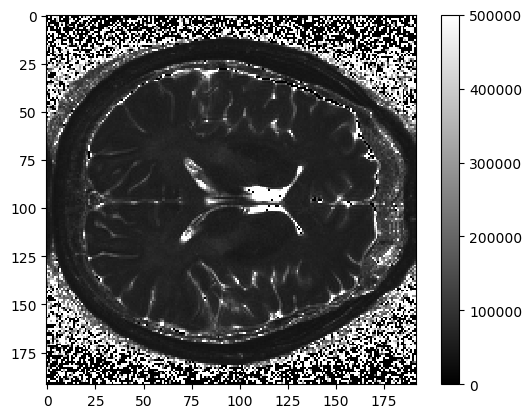

PyObject <matplotlib.colorbar.Colorbar object at 0x134ee76d0>

In [9]:
figure(1); imshow(T2map[:,:,3],vmin=0,vmax=120000,cmap="gray",interpolation="none");colorbar()
figure(2); imshow(T2map[:,:,3],vmin=0,vmax=500000,cmap="gray",interpolation="none");colorbar()

### Saving T2 map to a NIFTI file

In [10]:
T2mapInt = deepcopy(T2map);
L = find(T2mapInt.>1000000);
T2mapInt[L] = 1000000;
L = find(T2mapInt.<0);
T2mapInt[L] = 0;
headerinfo["cal_max"] = Float32(200000);
headerinfo["cal_min"] = Float32(0);
headerinfo["datatype"] = Int16(16)
T2mapInt = convert(Array{Float32,3}, T2mapInt)
newFileName = "data/T2map.nii"
headerinfo["dim"][1:5]=[3,size(T2map)[1],size(T2map)[2],size(T2map)[3],1]
write_nii_header(newFileName, headerinfo);
fid = open(newFileName,"a");
write(fid, T2mapInt);
close(fid);

### Homework for psychology students
* Measure the T2 values for GM, WM, and CSF
* Summarize this paper: [http://onlinelibrary.wiley.com/doi/10.1002/mrm.1910140108/abstract] and produce figures similar to FIG 1a 1b and FIG 2 of the paper
* *Optional:* Display T1-weighted images in the data directory

### Homework for ECE students
* Measure the T2 values for GM, WM and CSF
* Calculate and save proton density maps
* **Potential research project**: dual exponential fitting in WM, GM ROIs